# Topic Modeling + Plots for Paper

## Setup

In [1]:
import pandas as pd
from datetime import date
from pathlib import Path
import matplotlib.ticker as mtick
import numpy as np
from scipy.stats import entropy
import seaborn as sns
import opinionated  # noqa
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use("opinionated_rc")

CITY_SHORTCODE_NAME_LUT = {
    "AA": "Ann Arbor, MI",
    "RO": "Royal Oak, MI",
    "JS": "Jackson, MI",
    "LS": "Lansing, MI",
    "RCH": "Richmond, VA",
    "SEA": "Seattle, WA",
    "OAK": "Oakland, CA",
}

CITIES_OF_INTEREST = [
    "AA",
    "RO",
    "JS",
    "LS",
    "SEA",
    "OAK",
    "RCH",
]

CITY_ORDER = [
    "Seattle, WA",  # 737,015
    "Oakland, CA",  # 440,646
    "Richmond, VA",  # ...
    "Ann Arbor, MI",  # 123,851
    "Lansing, MI",  # 112,644
    "Royal Oak, MI",  # 58,211
    "Jackson, MI",  # 31,309
]

TOPIC_SEEDS = {
    "Housing": [
        "zoning",
        "construction",
        "redevelopment",
        "growth",
        "planning",
        "housing",
        "rent",
        "single family",
        "duplex",
        "apartment",
        "subdivision",
        "renting",
        "rental",
        "landlord",
        "tenant",
        "property",
    ],
    "Transportation and Mobility": [
        "public transit",
        "traffic",
        "bus",
        "car",
        "bike lanes",
        "pedestrian",
        "parking",
        "crosswalk",
    ],
    "Public Safety and Law Enforcement": [
        "police",
        "crime",
        "emergency",
        "safety",
        "property",
        "theft",
        "violence",
        "gun",
        "PD",
    ],
    "Environment and Sustainability": [
        "climate",
        "green",
        "conservation",
        "energy",
        "solar",
        "carbon",
        "pollinators",
        "mow",
        "flood",
        "drought",
        "fire",
    ],
    "Homelessness": [
        "homeless",
        "eviction",
        "shelter",
        "outreach",
        "mental health",
        "substance abuse",
        "housing",
    ],
    "Parks and Recreation": [
        "parks",
        "outdoors",
        "community",
        "events",
        "greenspace",
        "tree",
        "playground",
    ],
    "Economic Development": [
        "business",
        "jobs",
        "tax",
        "revitalization",
        "store",
        "main street",
        "shops",
        "local",
        "cannabis",
    ],
    "Arts and Culture": [
        "events",
        "festivals",
        "museums",
        "performances",
        "sculpture",
        "public art",
        "mural",
        "art",
    ],
    "Education and Youth Services": [
        "schools",
        "libraries",
        "programs",
        "youth",
        "kids",
        "students",
        "teaching",
        "training",
        "games",
        "sports",
    ],
    "Governance and Civic Engagement": [
        "transparency",
        "public participation",
        "elections",
        "accountability",
        "mayor",
        "council",
    ],
    "Israel-Palestine": [
        "Israel",
        "Palestine",
        "genocide",
        "Hamas",
        "Jewish",
        "Muslim",
        "discrimination",
        "Gaza",
        "ceasefire",
    ],
    "Police Reform": [
        "accountability",
        "community oversight",
        "training",
        "defund",
        "reform",
        "police",
        "traffic stops",
        "cops",
        "law",
    ],
    "Utilities": [
        "water",
        "electricity",
        "sewage",
        "internet",
        "utilities",
        "services",
        "DTE",
        "waste",
        "outage",
        "disruption",
        "trees",
        "storm",
        "rates",
        "shutoffs",
        "recycling",
    ],
    "General Community Organizing": [
        "community",
        "services",
        "access",
        "better",
        "organizing",
        "events",
        "accountability ",
        "accountable",
        "help",
        "youth",
        "organization",
        "funding",
        "funds",
        "protect",
        "preserve",
        "group ",
        "petition",
    ],
    "Urban Development": [
        "beautification",
        "historic projects",
        "district",
        "area",
        "history",
        "preservation",
        "development",
        "coliseum",
        "scenic",
        "holiday",
        "lights",
        "tourist",
    ],
}

ANNOTATIONS_DIR = Path("../data/annotated-for-modeling/").resolve()
FULL_TOPIC_CLASSIFIED_COMMENTS_PATH = Path("../data/full-comment-data-with-topics.csv").resolve()

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Get the bold color map values
# PALETTE_BOLD = cmaps.bold._colors
COLORBREWER_PALETTE = np.array(
    [
        [27, 158, 119],  # green
        [217, 95, 2],  # orange
        [117, 112, 179],  # purple
    ]
)
COLORBREWER_PALETTE = COLORBREWER_PALETTE / 255
sns.set_palette(COLORBREWER_PALETTE)

## Data Cleaning and Subsetting

In [3]:
# Store all data to single object
data_dfs = []

def split_short_name_to_city_and_date(short_name: str) -> tuple[str, date]:
    # Split the short name into city and date
    short_code_and_date_parts = short_name.split("_")

    # Short code is the first part
    short_code = short_code_and_date_parts[0]

    # Date is the rest in month day two-digit-year format
    event_date = date(
        year=int("20" + short_code_and_date_parts[-1]),
        month=int(short_code_and_date_parts[1]),
        day=int(short_code_and_date_parts[2]),
    )

    return short_code, event_date


# Read all data
for filepath in ANNOTATIONS_DIR.glob("*.csv"):
    # Read the comment data
    df = pd.read_csv(filepath)

    # Lowercase all columns
    df.columns = df.columns.str.lower()

    # Remove any spaces from column names and replace with "_"
    df.columns = df.columns.str.replace(" ", "_")

    # Split the "name" column into "city_short_code" and "date"
    df["city_short_code"], df["date"] = zip(
        *df["name"].apply(split_short_name_to_city_and_date),
        strict=True,
    )

    # Add the city name
    df["city_name"] = df["city_short_code"].map(CITY_SHORTCODE_NAME_LUT)

    # Using the filename, mark if this was a "training" or "inferred" dataset
    df["dataset_portion"] = filepath.stem.split("_")[-1]

    # Add the truth data to the list
    data_dfs.append(df)

# Concatenate all training data
full_data = pd.concat(data_dfs)

# Replace dataset portion with standard names
full_data["dataset_portion"] = full_data["dataset_portion"].replace(
    {"truth": "Training", "pred": "Inferred", "val": "Validation"}
)

# Subset the data to only the columns we care about
full_data = full_data[
    [
        "city_short_code",
        "city_name",
        "date",
        "dataset_portion",
        "meeting_section",
        "speaker_role",
        "start",
        "end",
        "model_pred_public_comment",
    ]
]

# Filter to only the cities of interest
full_data = full_data[full_data["city_short_code"].isin(CITIES_OF_INTEREST)]

full_data.sample(3)

,city_short_code,city_name,date,dataset_portion,meeting_section,speaker_role,start,end,model_pred_public_comment
193,JS,"Jackson, MI",2023-08-15,Inferred,Other,Other,11059.0,11060.0,0.0
630,LS,"Lansing, MI",2023-02-27,Training,Other,Other,499.0,500.0,NaN
2145,JS,"Jackson, MI",2023-05-09,Training,Public Comment,Commenter,1593.0,1755.0,NaN


## Dataset Distribution Metrics

In [4]:
# Compute metrics on a per-meeting basis (city-name + date tuple)
metrics_list = []
for (city_name, meeting_date), group in full_data.groupby(["city_name", "date"]):
    # Get the total number of comments for this city and date
    public_comments_count = len(
        full_data[
            (full_data["city_name"] == city_name)
            & (full_data["date"] == meeting_date)
            & (full_data["meeting_section"] == "Public Comment")
            & (full_data["speaker_role"] == "Commenter")
        ]
    )

    # Get the total number of comments for this city
    total_city_public_comments_count = len(
        full_data[
            (full_data["city_name"] == city_name)
            & (full_data["meeting_section"] == "Public Comment")
            & (full_data["speaker_role"] == "Commenter")
        ]
    )

    # Calculate the percent of comments
    percent_of_public_comments = (public_comments_count / total_city_public_comments_count) * 100

    # Get total utterances for meeting
    utterances_count = len(
        full_data[
            (full_data["city_name"] == city_name)
            & (full_data["date"] == meeting_date)
        ]
    )

    # Calculate percent of utterances are public comment
    percent_of_utterances = (public_comments_count / utterances_count) * 100

    # Add to the list
    metrics_list.append(
        {
            "city_name": city_name,
            "Date": meeting_date,
            "Dataset Portion": group.iloc[0]["dataset_portion"],
            "Public Comments": public_comments_count,
            "percent_of_total_comments": percent_of_public_comments,
            "Utterances": utterances_count,
            "percent_of_meeting_utterances": percent_of_utterances,
        }
    )

# Convert to dataframe
per_meeting_metrics_df = pd.DataFrame(metrics_list)
per_meeting_metrics_df = per_meeting_metrics_df.sort_values("Date", ascending=True)

### Percent Public Comment Contribution towards City Total

Contribution of public comments for each meeting towards 
each city council's total public comments (as a percent of the city-level total). 
Per-meeting public comment contribution bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.


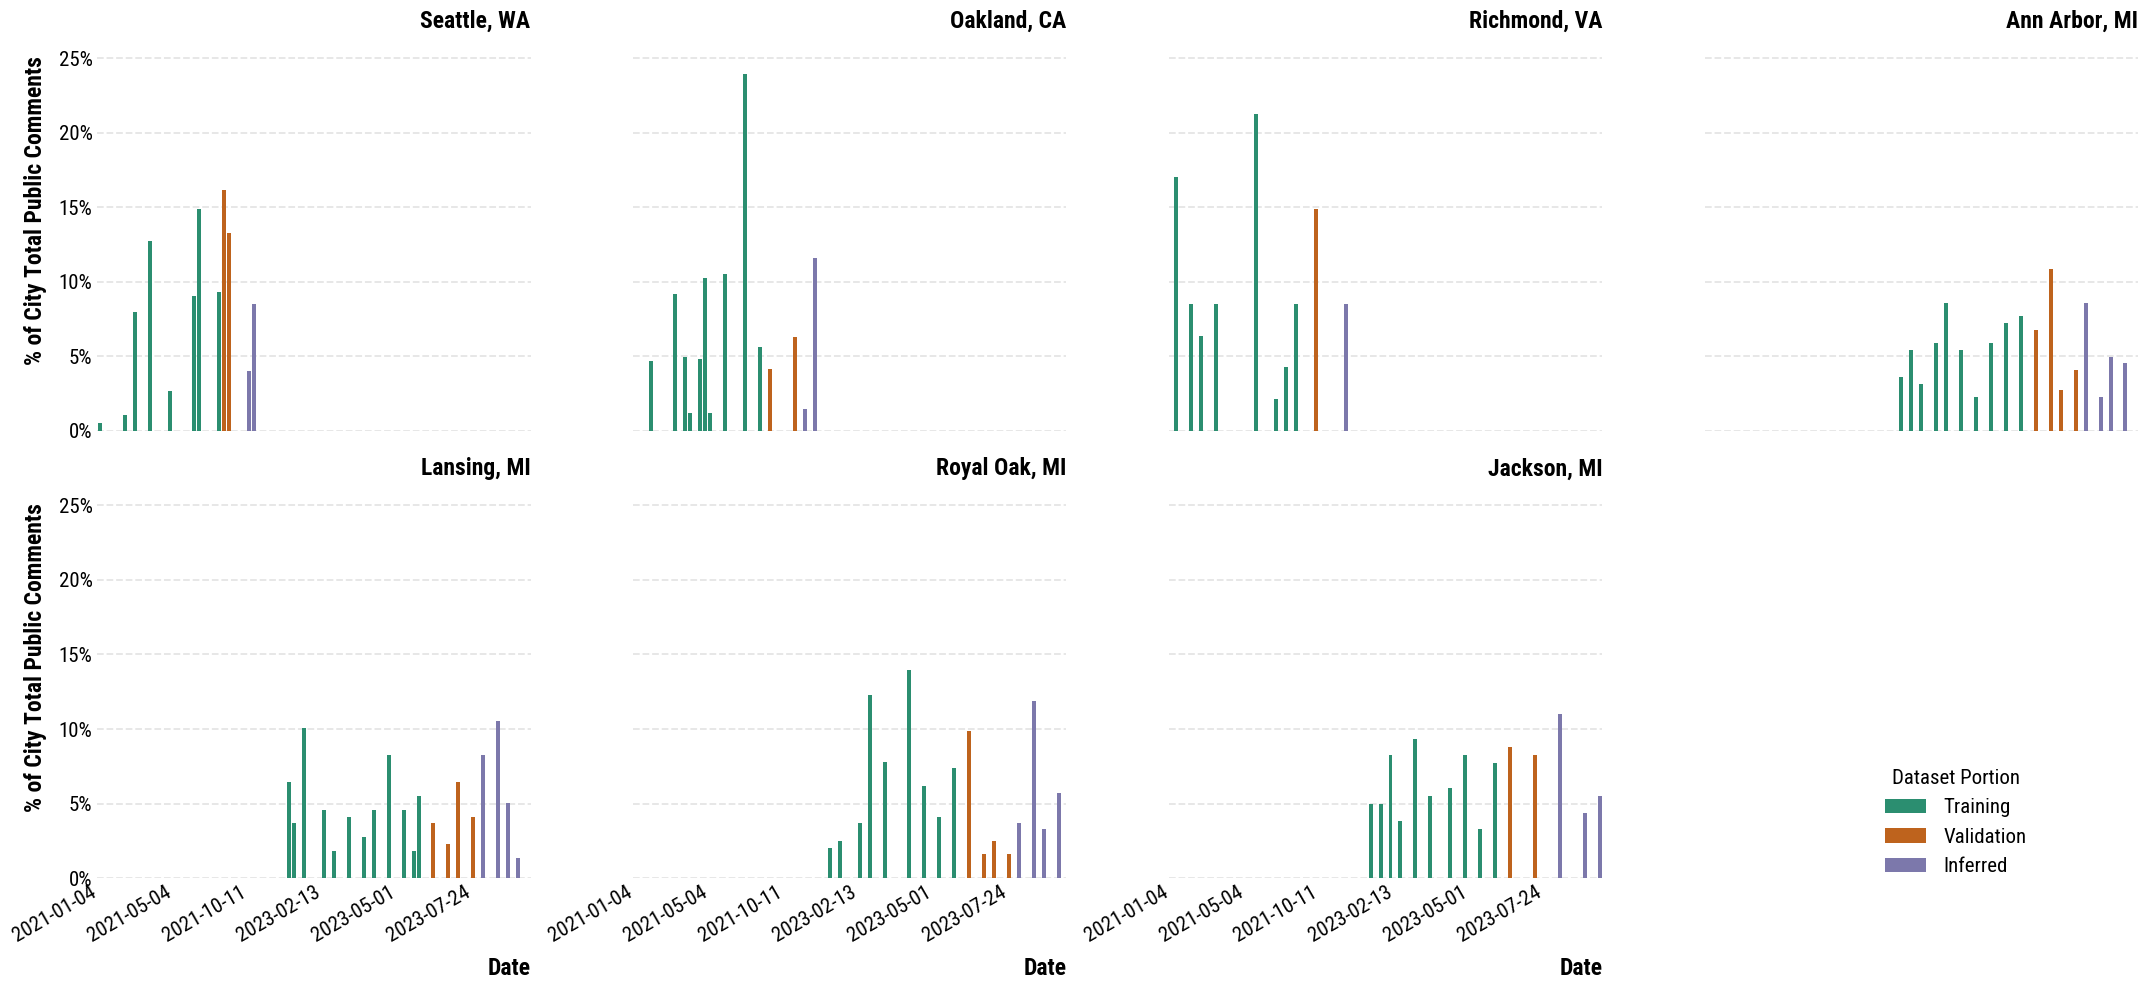

In [5]:
# Col by city
g = sns.catplot(
    data=per_meeting_metrics_df,
    x="Date",
    y="percent_of_total_comments",
    hue="Dataset Portion",
    hue_order=["Training", "Validation", "Inferred"],
    col="city_name",
    col_wrap=4,
    col_order=CITY_ORDER,
    kind="bar",
)

# Update the x-axis, and y-axis labels
g.set_axis_labels("Date", "% of City Total Public Comments")
g.figure.autofmt_xdate()
g.set_titles("")
g.set_titles("{col_name}", loc="right")

# For each ax in the figure, add x-axis ticks and labels
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Move the legend into the lower right of the plot, instead of the figure
sns.move_legend(g, "lower right", bbox_to_anchor=(0.95, 0.1))

# Add vertical spacing between the plots
g.figure.subplots_adjust(hspace=0.5)

# Tight Layout
g.figure.tight_layout()

fig_text = """
Contribution of public comments for each meeting towards 
each city council's total public comments (as a percent of the city-level total). 
Per-meeting public comment contribution bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.
""".strip()

print(fig_text)

### Public Comment Contribution per Meeting

Number of public comments provided per meeting.
Per-meeting bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.


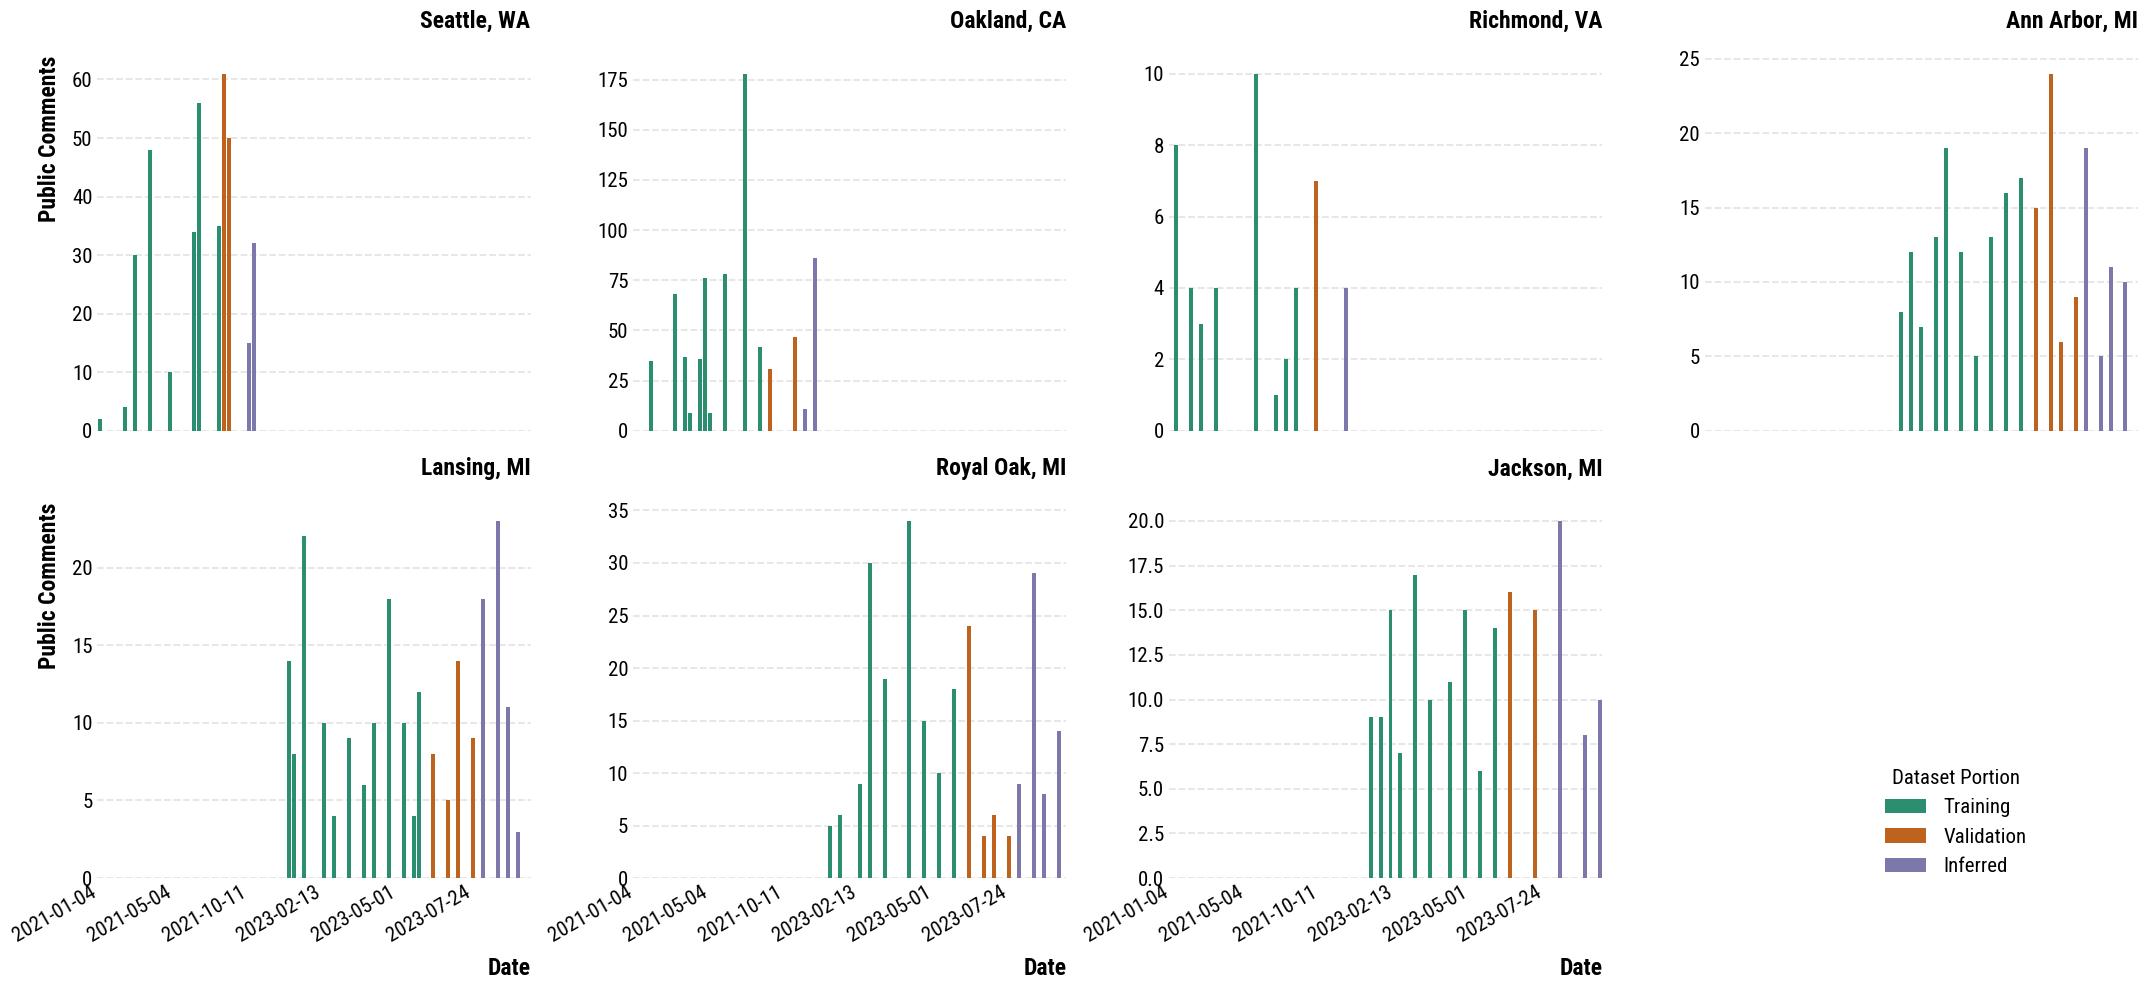

In [6]:
# Col by city
g = sns.catplot(
    data=per_meeting_metrics_df,
    x="Date",
    y="Public Comments",
    hue="Dataset Portion",
    hue_order=["Training", "Validation", "Inferred"],
    col="city_name",
    col_wrap=4,
    col_order=CITY_ORDER,
    kind="bar",
    sharey=False,
)

# Update the x-axis, and y-axis labels
g.figure.autofmt_xdate()
g.set_titles("")
g.set_titles("{col_name}", loc="right")

# For each ax in the figure, add x-axis ticks and labels
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))

# Move the legend into the lower right of the plot, instead of the figure
sns.move_legend(g, "lower right", bbox_to_anchor=(0.95, 0.1))

# Add vertical spacing between the plots
g.figure.subplots_adjust(hspace=0.5)

# Tight Layout
g.figure.tight_layout()

fig_text = """
Number of public comments provided per meeting.
Per-meeting bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.
""".strip()

print(fig_text)

### Percent Public Comment from Total Meeting Utterances

Percent of each meeting's discussion was public comment.
Per-meeting public comment discussion bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.


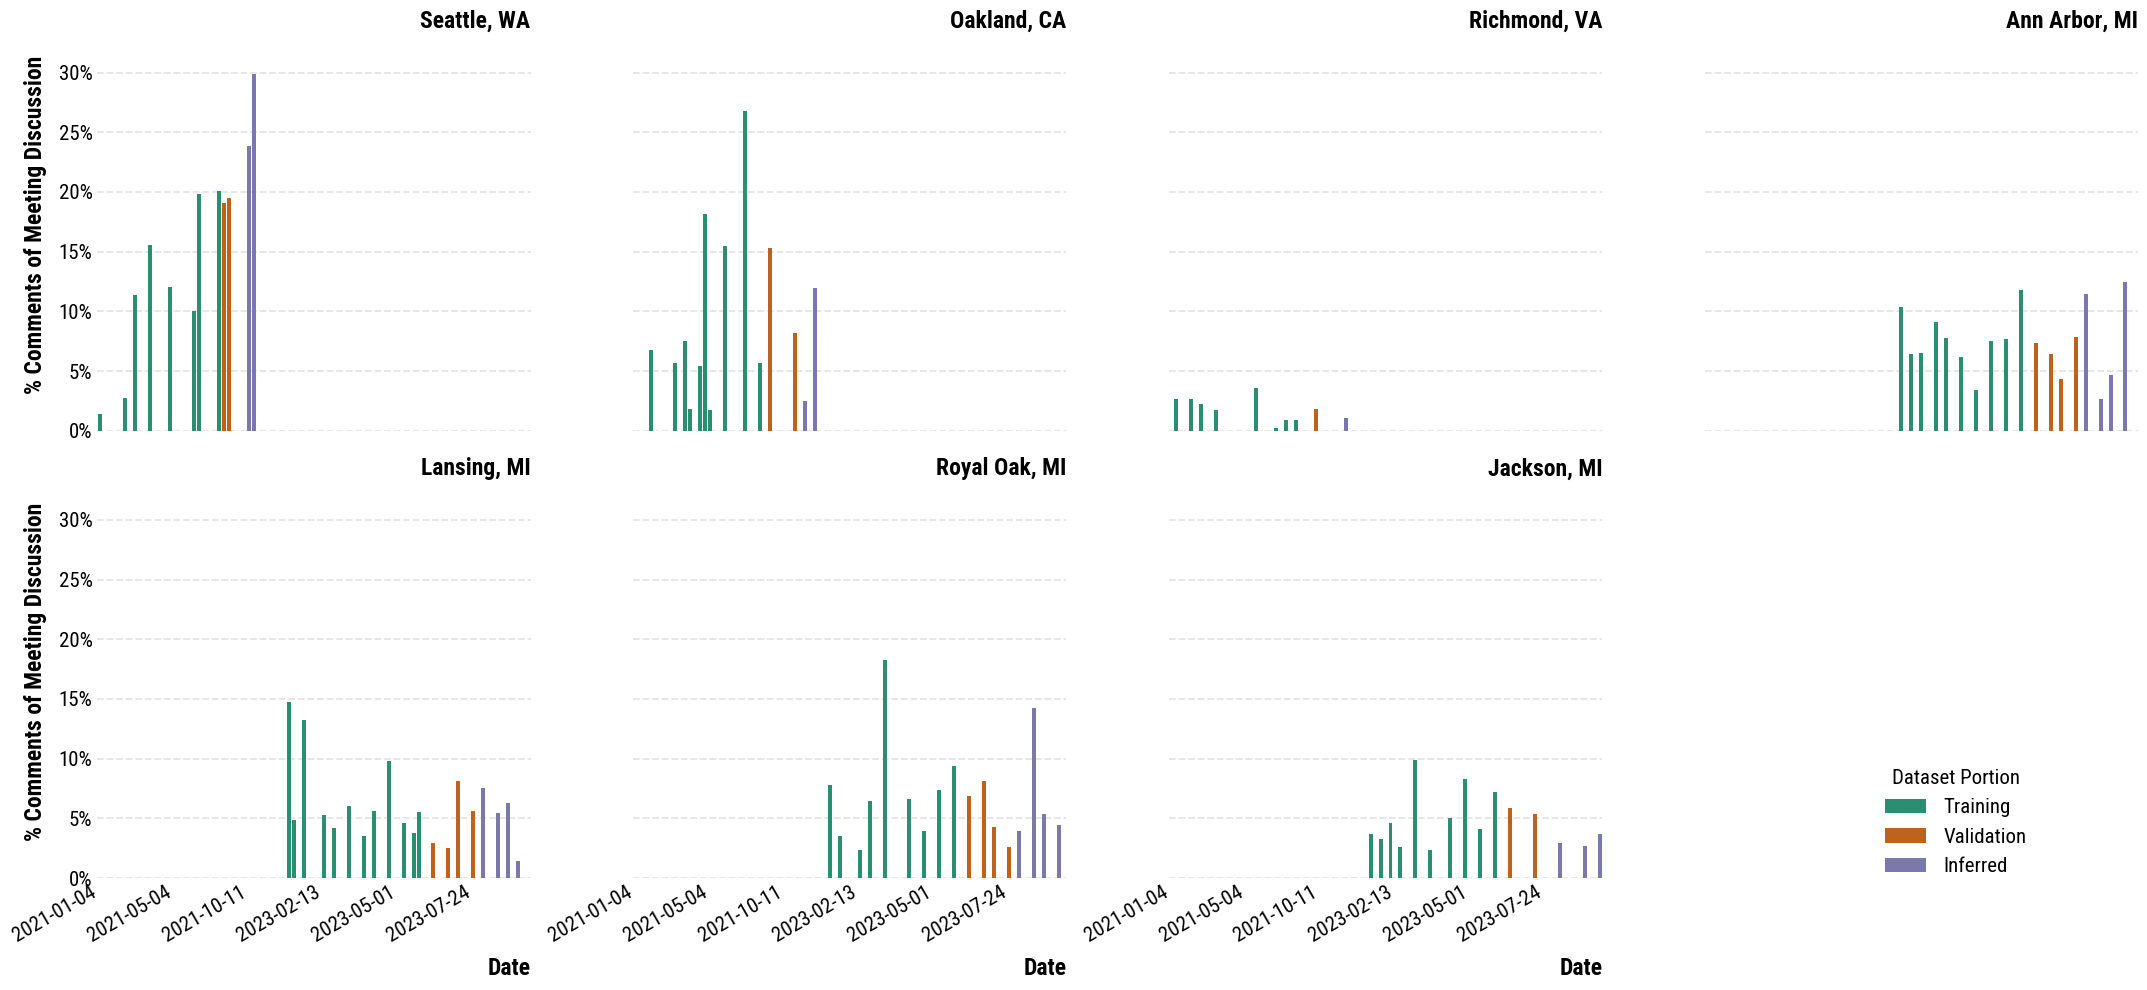

In [7]:
# Col by city
g = sns.catplot(
    data=per_meeting_metrics_df,
    x="Date",
    y="percent_of_meeting_utterances",
    hue="Dataset Portion",
    hue_order=["Training", "Validation", "Inferred"],
    col="city_name",
    col_wrap=4,
    col_order=CITY_ORDER,
    kind="bar",
)

# Update the x-axis, and y-axis labels
g.set_axis_labels("Date", "% Comments of Meeting Discussion")
g.figure.autofmt_xdate()
g.set_titles("")
g.set_titles("{col_name}", loc="right")

# For each ax in the figure, add x-axis ticks and labels
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mtick.MaxNLocator(6))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

# Move the legend into the lower right of the plot, instead of the figure
sns.move_legend(g, "lower right", bbox_to_anchor=(0.95, 0.1))

# Add vertical spacing between the plots
g.figure.subplots_adjust(hspace=0.5)

# Tight Layout
g.figure.tight_layout()

fig_text = """
Percent of each meeting's discussion was public comment.
Per-meeting public comment discussion bars are colored by which portion of
the overall city-level dataset they contributed to: Training, Validation, or Inferred.
""".strip()

print(fig_text)

## Topic Modeling

In [8]:
# Read the full comment data with topics
plotting_comments = pd.read_csv(FULL_TOPIC_CLASSIFIED_COMMENTS_PATH)

# Filter out any non-approved topics
plotting_comments = plotting_comments[
    plotting_comments["topic"].isin(TOPIC_SEEDS.keys())
]

# Create palette for heatmaps
heatmap_palette = np.array([
    [255, 255, 229],
    [255, 247, 188],
    [254, 227, 145],
    [254, 196, 79],
    [254, 153, 41],
    [236, 112, 20],
    [204, 76, 2],
    [153, 52, 4],
    [102, 37, 6],
])

heatmap_palette = (heatmap_palette / 255).tolist()

### Topic Distribution of Comments Overall

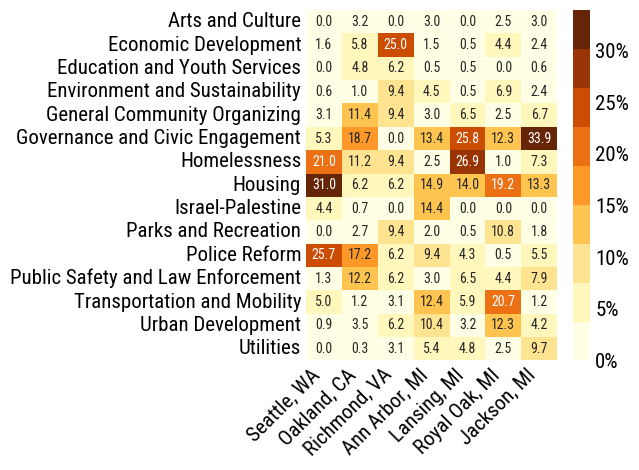

In [9]:
# Create topic name and city count dataframe
topic_city_counts = (
    plotting_comments.groupby(["city_name", "topic"])
    .size()
    .reset_index(name="comment_count")
)

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city_name")[
    "comment_count"
].transform(lambda x: (x / x.sum()) * 100)

# For each city and each topic, if it doesn't exist, add a 0 count
for city in CITY_ORDER:
    for topic in TOPIC_SEEDS.keys():
        if not topic_city_counts[
            (topic_city_counts["city_name"] == city) & (topic_city_counts["topic"] == topic)
        ].empty:
            continue

        topic_city_counts = pd.concat([
            topic_city_counts,
            pd.DataFrame(
                {
                    "city_name": [city],
                    "topic": [topic],
                    "comment_count": [0],
                    "comment_pct": [0],
                }
            ),
        ])

# Always order data by population
topic_city_counts["city_name"] = pd.Categorical(
    topic_city_counts["city_name"], categories=CITY_ORDER, ordered=True
)

# Heatmap of topic percentage per month per city
ax = sns.heatmap(
    data=topic_city_counts.pivot(
        index="topic", columns="city_name", values="comment_pct"
    ),
    annot=True,
    fmt=".1f",
    cmap=heatmap_palette,
    cbar_kws={"format": mtick.PercentFormatter(decimals=0)},
)

# Remove x and y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

_ = plt.xticks(rotation=45, ha="right")

plt.tight_layout()

### Topic Distribution of Inferred (True) Comments

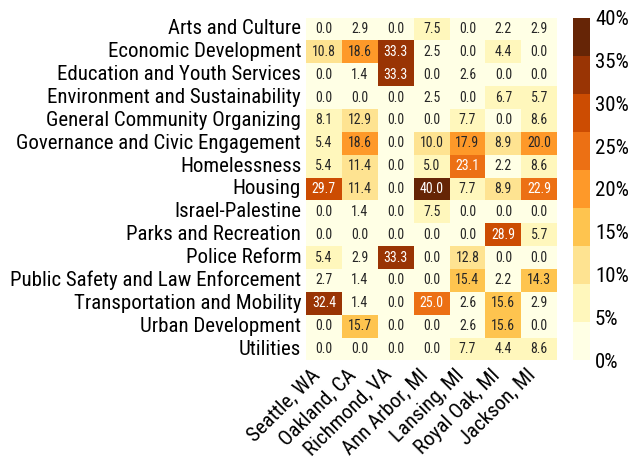

In [10]:
inferred_true_comments = plotting_comments[
    plotting_comments["dataset_portion"] == "Inferred"
]

# Create topic name and city count dataframe
topic_city_counts = (
    inferred_true_comments.groupby(["city_name", "topic"])
    .size()
    .reset_index(name="comment_count")
)

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city_name")[
    "comment_count"
].transform(lambda x: (x / x.sum()) * 100)

# For each city and each topic, if it doesn't exist, add a 0 count
for city in CITY_ORDER:
    for topic in TOPIC_SEEDS.keys():
        if not topic_city_counts[
            (topic_city_counts["city_name"] == city) & (topic_city_counts["topic"] == topic)
        ].empty:
            continue

        topic_city_counts = pd.concat([
            topic_city_counts,
            pd.DataFrame(
                {
                    "city_name": [city],
                    "topic": [topic],
                    "comment_count": [0],
                    "comment_pct": [0],
                }
            ),
        ])

# Always order data by population
topic_city_counts["city_name"] = pd.Categorical(
    topic_city_counts["city_name"], categories=CITY_ORDER, ordered=True
)

# Heatmap of topic percentage per month per city
ax = sns.heatmap(
    data=topic_city_counts.pivot(
        index="topic", columns="city_name", values="comment_pct"
    ),
    annot=True,
    fmt=".1f",
    cmap=heatmap_palette,
    cbar_kws={"format": mtick.PercentFormatter(decimals=0)},
)

# Remove x and y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

_ = plt.xticks(rotation=45, ha="right")

plt.tight_layout()

### Topic Distribution of Inferred (Inferred) Comments

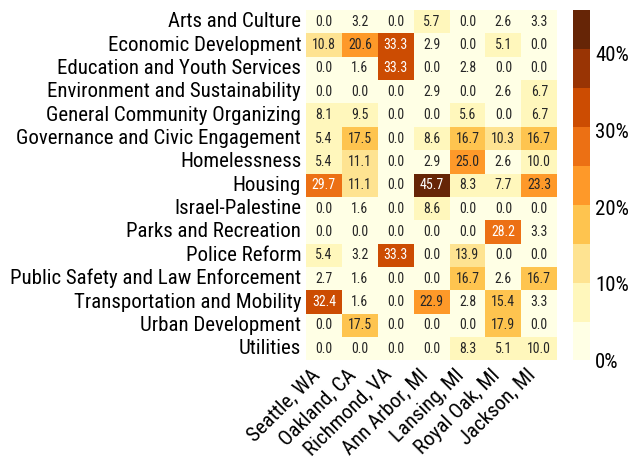

In [11]:
# Join the topic data back with the original data
# Join on the name and the start and end times
inferred_inferred_comments = plotting_comments[
    plotting_comments["dataset_portion"] == "Inferred"
].merge(
    full_data[["city_name", "start", "end", "model_pred_public_comment"]],
    on=["city_name", "start", "end"],
)

# Select down to only the comments that were predicted to be public comments
inferred_inferred_comments = inferred_inferred_comments[
    inferred_inferred_comments["model_pred_public_comment"] == 1
]

# Remove non-approved topics
inferred_inferred_comments = inferred_inferred_comments[
    inferred_inferred_comments["topic"].isin(TOPIC_SEEDS.keys())
]

# Create topic name and city count dataframe
topic_city_counts = (
    inferred_inferred_comments.groupby(["city_name", "topic"])
    .size()
    .reset_index(name="comment_count")
)

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city_name")[
    "comment_count"
].transform(lambda x: (x / x.sum()) * 100)

# For each city and each topic, if it doesn't exist, add a 0 count
for city in CITY_ORDER:
    for topic in TOPIC_SEEDS.keys():
        if not topic_city_counts[
            (topic_city_counts["city_name"] == city) & (topic_city_counts["topic"] == topic)
        ].empty:
            continue

        topic_city_counts = pd.concat([
            topic_city_counts,
            pd.DataFrame(
                {
                    "city_name": [city],
                    "topic": [topic],
                    "comment_count": [0],
                    "comment_pct": [0],
                }
            ),
        ])

# Always order data by population
topic_city_counts["city_name"] = pd.Categorical(
    topic_city_counts["city_name"], categories=CITY_ORDER, ordered=True
)

# Heatmap of topic percentage per month per city
ax = sns.heatmap(
    data=topic_city_counts.pivot(
        index="topic", columns="city_name", values="comment_pct"
    ),
    annot=True,
    fmt=".1f",
    cmap=heatmap_palette,
    cbar_kws={"format": mtick.PercentFormatter(decimals=0)},
)

# Remove x and y axis labels
ax.set_xlabel("")
ax.set_ylabel("")

_ = plt.xticks(rotation=45, ha="right")

plt.tight_layout()

## Safety Checks on Model

In [12]:
# LM plot with F1 of model + number of comments
city_name_f1_lut = {
    "Ann Arbor, MI": 0.894,
    "Royal Oak, MI": 0.811,
    "Jackson, MI": 0.870,
    "Lansing, MI": 0.611,
    "Seattle, WA": 0.929,
    "Oakland, CA": 0.785,
    "Richmond, VA": 1.000,
}

city_name_k_alpha_lut = {
    "Ann Arbor, MI": 0.918,
    "Royal Oak, MI": 0.931,
    "Jackson, MI": 0.876,
    "Lansing, MI": 0.953,
    "Seattle, WA": 0.982,
    "Oakland, CA": 0.900,
    "Richmond, VA": 0.831,
}

city_name_percent_white_lut = {
    "Ann Arbor, MI": 0.68,
    "Royal Oak, MI": 0.86,
    "Jackson, MI": 0.65,
    "Lansing, MI": 0.55,
    "Seattle, WA": 0.59,
    "Oakland, CA": 0.30,
    "Richmond, VA": 0.43,
}

city_name_percent_bach_lut = {
    "Ann Arbor, MI": 0.79,
    "Royal Oak, MI": 0.61,
    "Jackson, MI": 0.15,
    "Lansing, MI": 0.30,
    "Seattle, WA": 0.67,
    "Oakland, CA": 0.51,
    "Richmond, VA": 0.46,
}

# Get count of comments in each city's training portion
city_comment_count_lut = (
    full_data[full_data["dataset_portion"] == "Training"]
    .groupby("city_name")
    .agg({"city_name": "count"})
)["city_name"].to_dict()

# Get entropy of topics in each city's training portion
city_topic_entropy_lut = (
    plotting_comments[plotting_comments["dataset_portion"] == "Training"]
    .groupby("city_name")["topic"]
    .value_counts(normalize=True)
    .groupby("city_name")
    .apply(entropy)
).to_dict()

# Create dataframe of city_name, f1, comment_count, and entropy(topic_percents)
city_metrics = []
for city_name in CITY_ORDER:
    city_metrics.append(
        {
            "city_name": city_name,
            "model_f1": city_name_f1_lut[city_name],
            "annotator_agreement": city_name_k_alpha_lut[city_name],
            "percent_white": city_name_percent_white_lut[city_name],
            "percent_bachelors": city_name_percent_bach_lut[city_name],
            "training_comment_count": city_comment_count_lut[city_name],
            "training_topic_entropy": city_topic_entropy_lut[city_name],
        }
    )

city_metrics_df = pd.DataFrame(city_metrics)
city_metrics_df

,city_name,model_f1,annotator_agreement,percent_white,percent_bachelors,training_comment_count,training_topic_entropy
0,"Seattle, WA",0.929,0.982,0.59,0.67,1734,1.451440
1,"Oakland, CA",0.785,0.900,0.30,0.51,6219,2.220653
2,"Richmond, VA",1.000,0.831,0.43,0.46,2620,2.046241
3,"Ann Arbor, MI",0.894,0.918,0.68,0.79,1624,2.401934
4,"Lansing, MI",0.611,0.953,0.55,0.30,1934,1.858886
5,"Royal Oak, MI",0.811,0.931,0.86,0.61,2553,2.104267
6,"Jackson, MI",0.870,0.876,0.65,0.15,2458,2.072526


<Axes: >

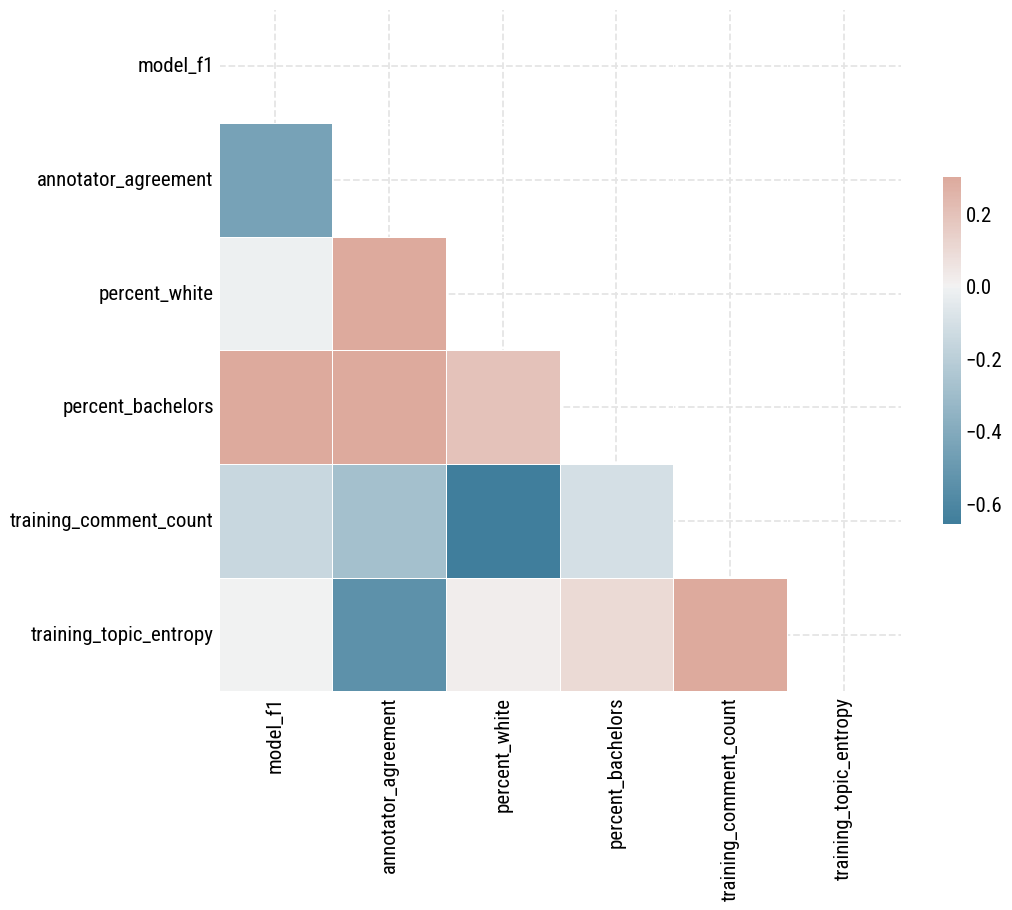

In [13]:
# Compute the correlation matrix
corr = city_metrics_df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Random Comments for Each Topic

In [14]:
# Filter plotting comments to only topics allowed
plotting_comments = plotting_comments[
    plotting_comments["topic"].isin(TOPIC_SEEDS.keys())
]

# Get three random comments from each topic
# Print them with topic: and then bullet point each comment
for topic in TOPIC_SEEDS.keys():
    print(f"Topic: {topic}")
    for comment in plotting_comments.loc[plotting_comments.topic == topic].sample(3)["text"]:
        print(f"- {comment}")
    print()

Topic: Housing
- Tim O'Donnell, 1212 East 14.
- Wow, okay.  So I'm Toby Berry. I am representing Community Action Agency and I just wanted to take a minute to thank you for entrusting me with my appointment to the Affordable Housing Development Board. I wasn't able to be here at the last meeting so I wanted to take that time to say thank you. I also want to let you know that Community Action Agency has published its latest community needs assessment. It can be found on our website under the Who We Are tab and reports.  It's a lengthy report because it does cover three counties, Jackson, Lenawee, and Hillsdale County, but it's rich in data and there might be some information in there that you can utilize.  I also just want to reiterate that Community Action Agency is committed to working with the city on issues related to homelessness and those living in poverty. I know it seems like there's some thoughts that we're feeling some kind of way about not being funded and that is not the cas